In [1]:
import gc
import os
import sys
sys.path.append("/workspace/mta_vision_transformers/")
from collections import OrderedDict
from typing import Any, Callable, Dict, List, Set, Tuple

import numpy as np
import einops
import torch
import torch.nn as nn
import torch.nn.functional as Fn
import torch.utils.data
from matplotlib import pyplot as plt
from tensordict import TensorDict
from torch.utils._pytree import tree_flatten

from core.monitor import Monitor
from infrastructure import utils
from infrastructure.settings import DEVICE, OUTPUT_DEVICE, DTYPE
from dataset.construct import ImageDataset
from dataset.library import DATASETS


dataset_name, n_classes = DATASETS["Common"][1]
OUTPUT_DIR = "experiments/random"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    
# Ocean: 901085904
# Rose: 100390212
torch.set_printoptions(linewidth=400, sci_mode=False)

Seed: None


In [ ]:
from modeling.image_features import ImageFeatures
from modeling.vit_random import OpenCLIPRandomViT
from visualize.base import construct_per_layer_output_dict


# SECTION: Set up model
torch.set_default_device(DEVICE)
model = OpenCLIPRandomViT(
    {"random_input"},
    layer_order=[*range(0, 15)],
    random_input_layer=3,
).to(DEVICE)


# SECTION: Set up monitor
def residual_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return input_ + tree_flatten(output_)[0][0]
    
def input_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return tree_flatten(input_)[0][0]

def weight_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return model_.weight.mT

def get_weight_by_name(name: str) -> Callable[[nn.Module, Any, Any], Any]:
    def hook(model_: nn.Module, input_: Any, output_: Any) -> Any:
        return utils.rgetattr(model_, name).data
    return hook

def attention_proj_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return tree_flatten(input_)[0][0] @ model_.in_proj_weight.mT + model_.in_proj_bias

def attention_matrix_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    return einops.rearrange(
        tree_flatten(output_)[0][0],
        "b h n1 n2 -> b n1 n2 h"
    ).to(OUTPUT_DEVICE)

def query_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    QKVw = model_.in_proj_weight
    QKVb = model_.in_proj_bias
    
    D = 1024
    Qw, Qb = QKVw[:D], QKVb[:D]
    Q = utils.linear_from_wb(Qw, Qb)
    return Q.forward(tree_flatten(input_)[0][0]).to(OUTPUT_DEVICE)

def key_hook_fn(model_: nn.Module, input_: Any, output_: Any) -> Any:
    QKVw = model_.in_proj_weight
    QKVb = model_.in_proj_bias
    
    D = 1024
    Kw, Kb = QKVw[D:2 * D], QKVb[D:2 * D]
    K = utils.linear_from_wb(Kw, Kb)
    return K.forward(tree_flatten(input_)[0][0]).to(OUTPUT_DEVICE)


monitor_config = OrderedDict({
    "model.visual.transformer.resblocks": OrderedDict({
        "": [
            # ("layer_input", input_hook_fn),
            ("layer_output", Monitor.default_hook_fn),
        ],
        # "ln_1": "layer_norm1_output",  # "norm1"
        "attn": [
            # ("attention_input", input_hook_fn),
            # ("query", query_hook_fn),
            # ("key", key_hook_fn),
            # ("attention_proj", attention_proj_hook_fn),
            # ("attention_output", Monitor.default_hook_fn),
            # ("attention_matrix", attention_matrix_hook_fn),
        ],
        # "ln_2": [
        #     ("intermediate_output", input_hook_fn),
        #     ("layer_norm2_output", Monitor.default_hook_fn),  # "norm2"
        # ],
        # "mlp": {
        #     "": "mlp_output",
        #     "c_fc": [
        #         # ("mlp_fc1_input", input_hook_fn),
        #         # ("mlp_fc1_output_no_bias", fc_no_bias_hook_fn),
        #         ("mlp_fc1_output", Monitor.default_hook_fn),
        #         # ("mlp_fc1_weight", weight_hook_fn),
        #     ],
        #     "gelu": [
        #         ("mlp_activation_output", Monitor.default_hook_fn),
        #     ],
        #     # # "c_proj": "mlp_fc2",
        # }
    })
})
monitor = Monitor(model, monitor_config)


# SECTION: Set up dataset
batch_size = 50
dataset = ImageDataset(dataset_name, split="train", return_original_image=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=torch.Generator(DEVICE))
original_images, images = next(iter(dataloader))


# SECTION: Run baseline model
per_metric_output_dict = monitor.reset()
with torch.no_grad():
    output = model.forward(images)

per_layer_output_dict = construct_per_layer_output_dict(per_metric_output_dict)


# SECTION: Construct ImageFeatures data structure
torch.set_default_device(OUTPUT_DEVICE)
features = ImageFeatures(per_layer_output_dict, {}, "default", DEVICE)

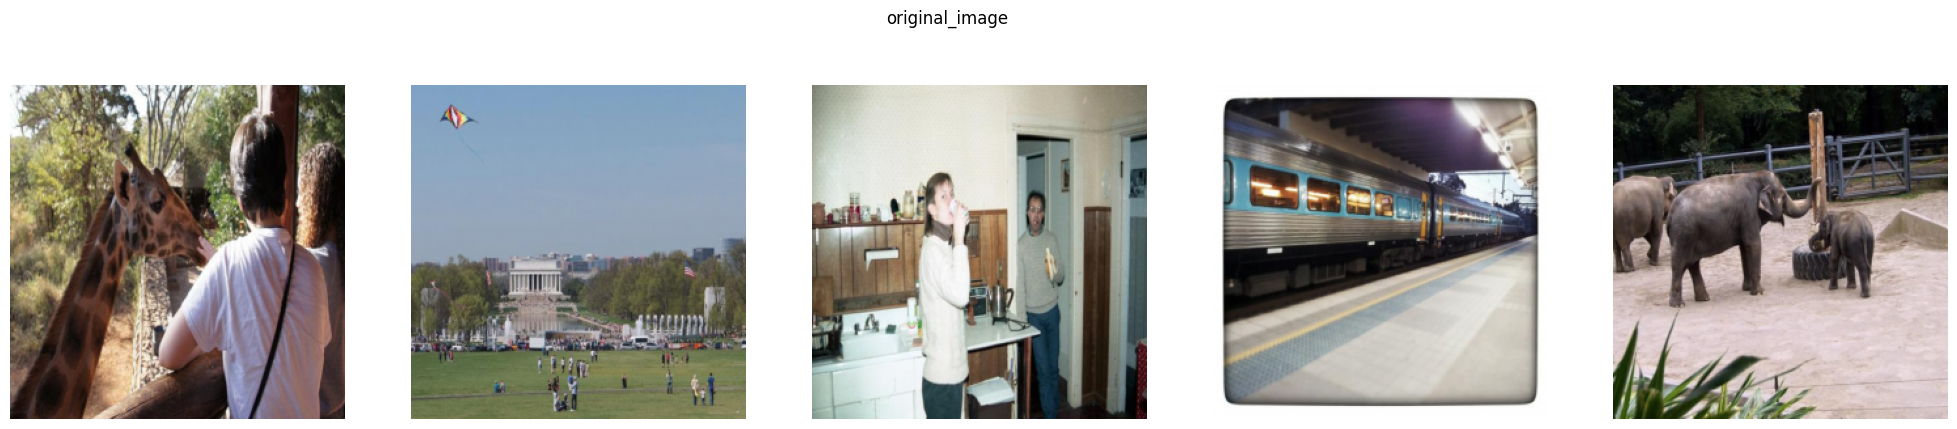

In [3]:
# SECTION: Visualize original images
%matplotlib inline
from core.attention_sink import mask_attention_sink
from visualize.base import (
    visualize_images_with_mta,
    get_rgb_colors,
)

# SECTION: Visualize image
visualize_images_with_mta(original_images.to(OUTPUT_DEVICE), None)

try:
    rgb_assignment
except NameError:
    color_layer_idx = 12    # min(mta_masks.keys())
    rgb_assignment = get_rgb_colors(features, color_layer_idx, "layer_output", False)

# highlight = torch.LongTensor((
#     (1, 5, 4),
#     (4, 15, 8),
# ))
# highlight = torch.load(f"{OUTPUT_DIR}/artifact_indices.pt")

Layer 0 ========================================================================================================================


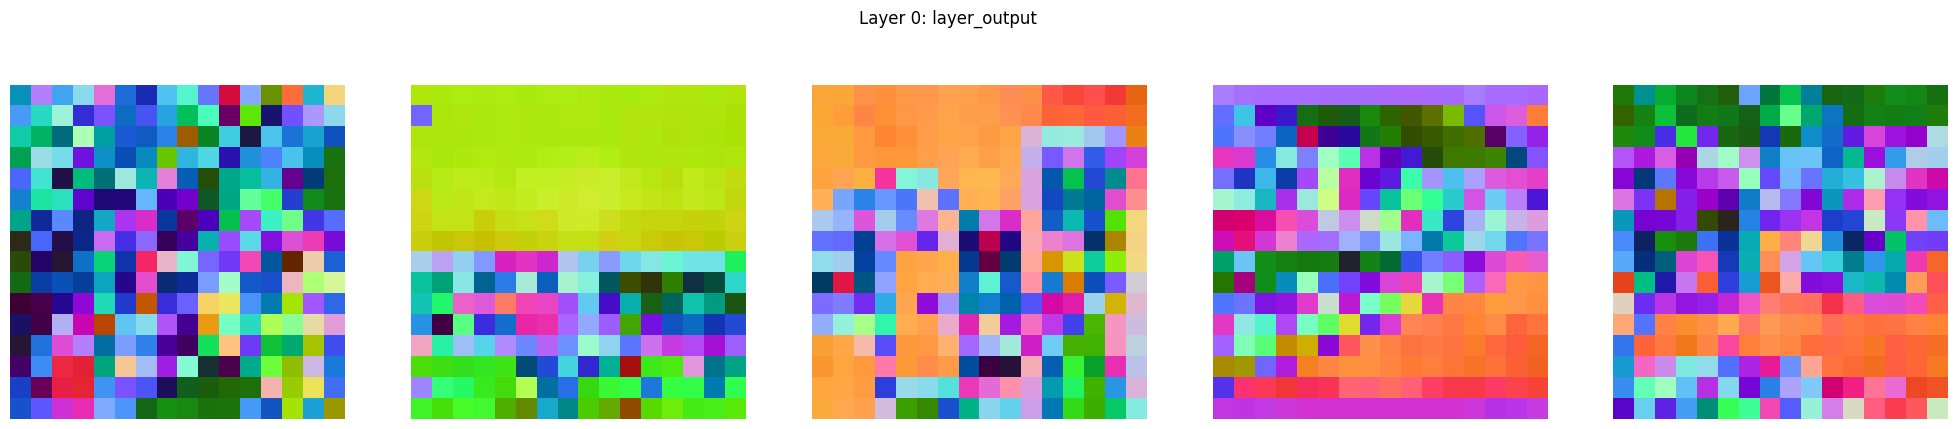

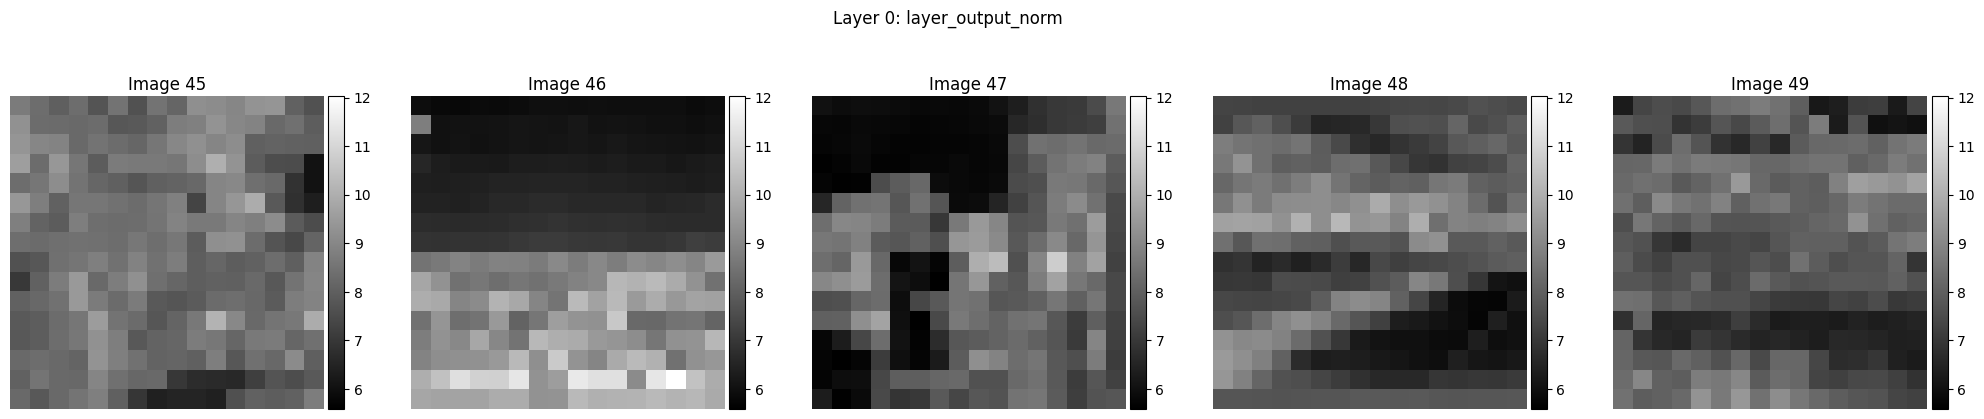

Layer 1 ========================================================================================================================


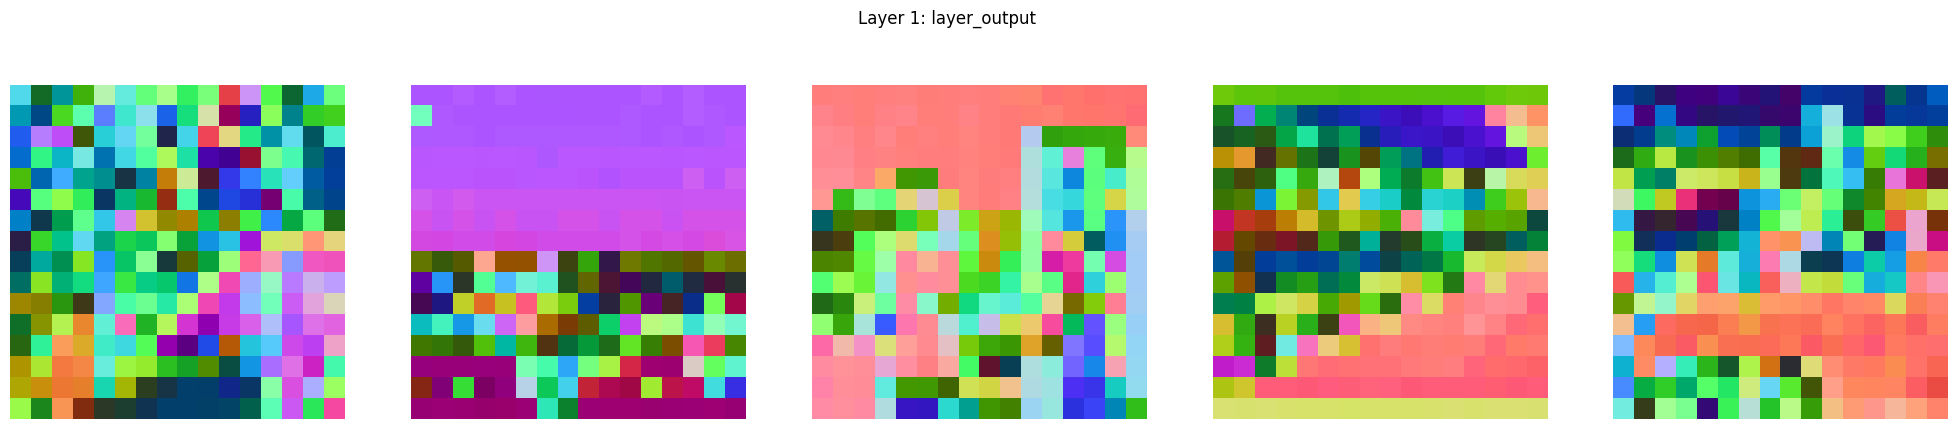

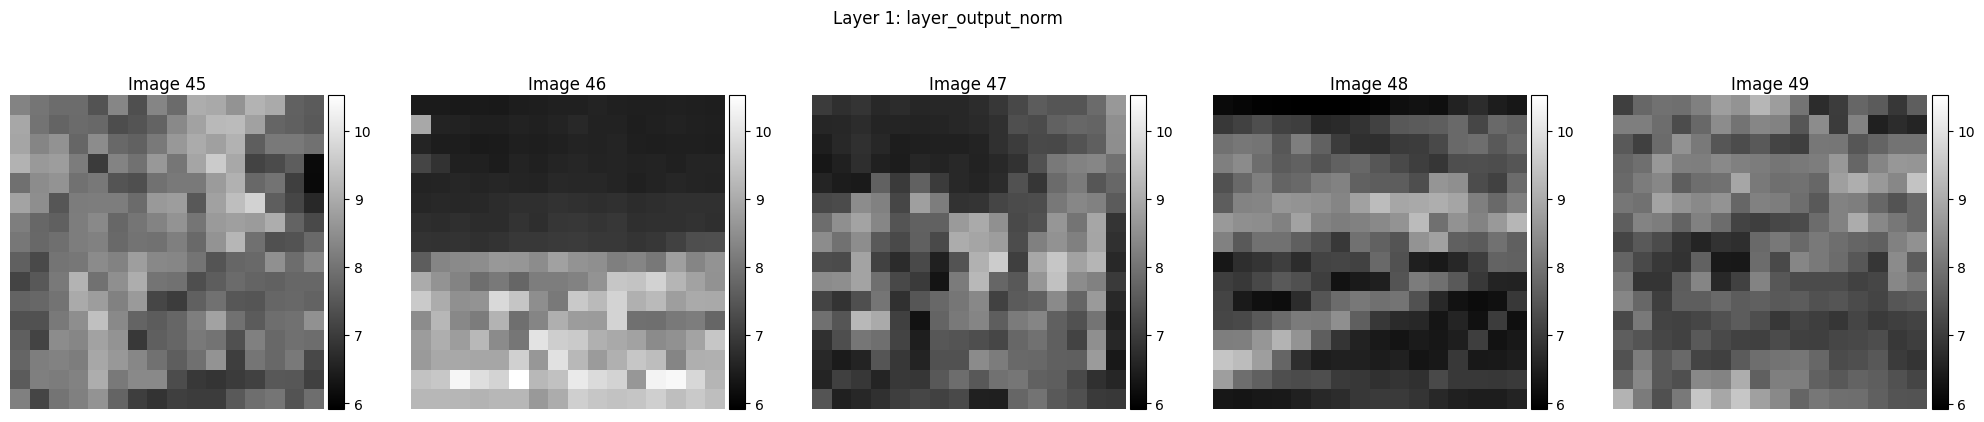

Layer 2 ========================================================================================================================


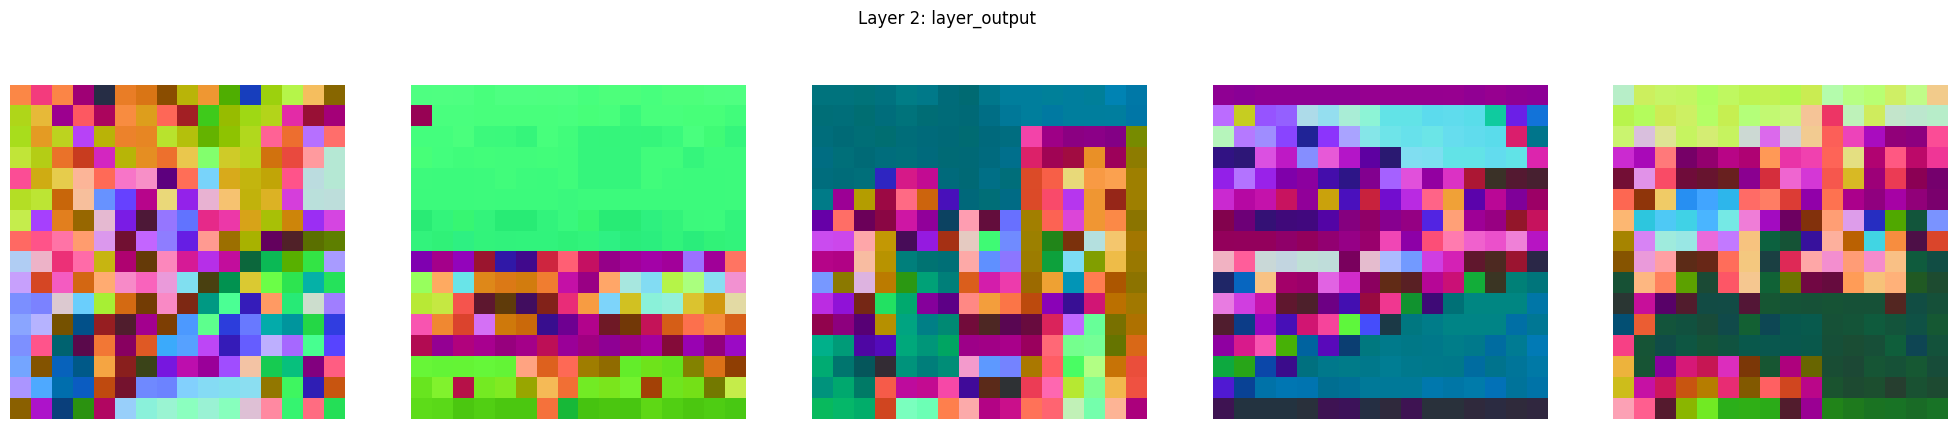

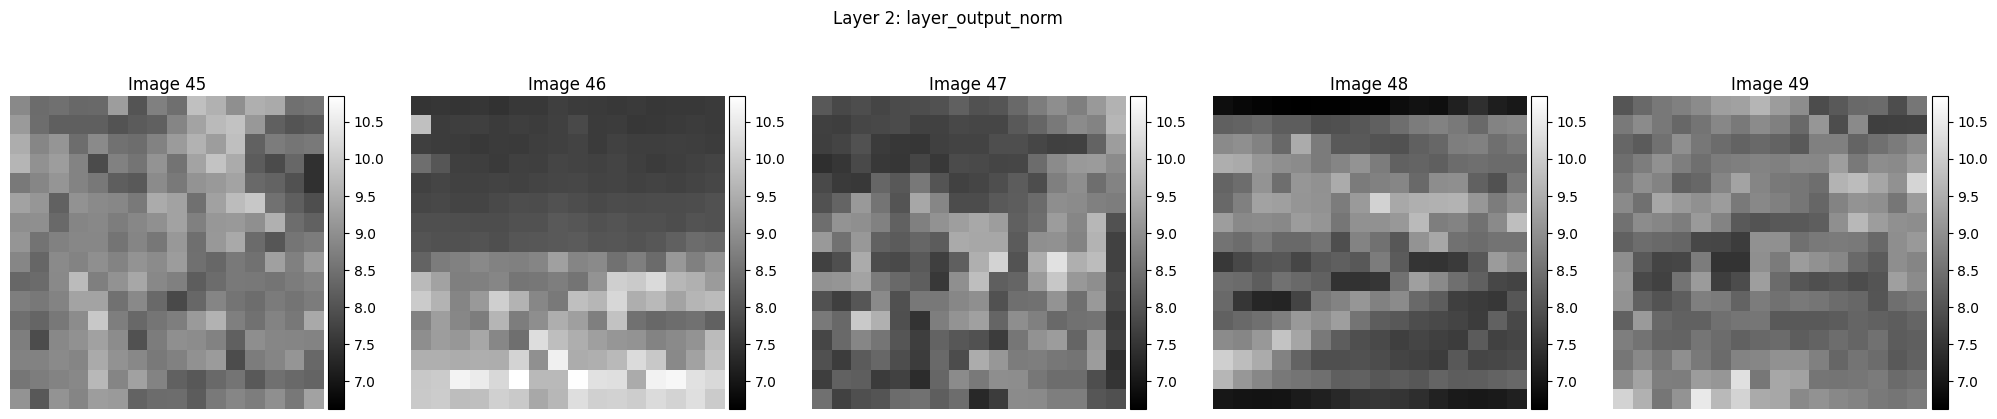

Layer 3 ========================================================================================================================


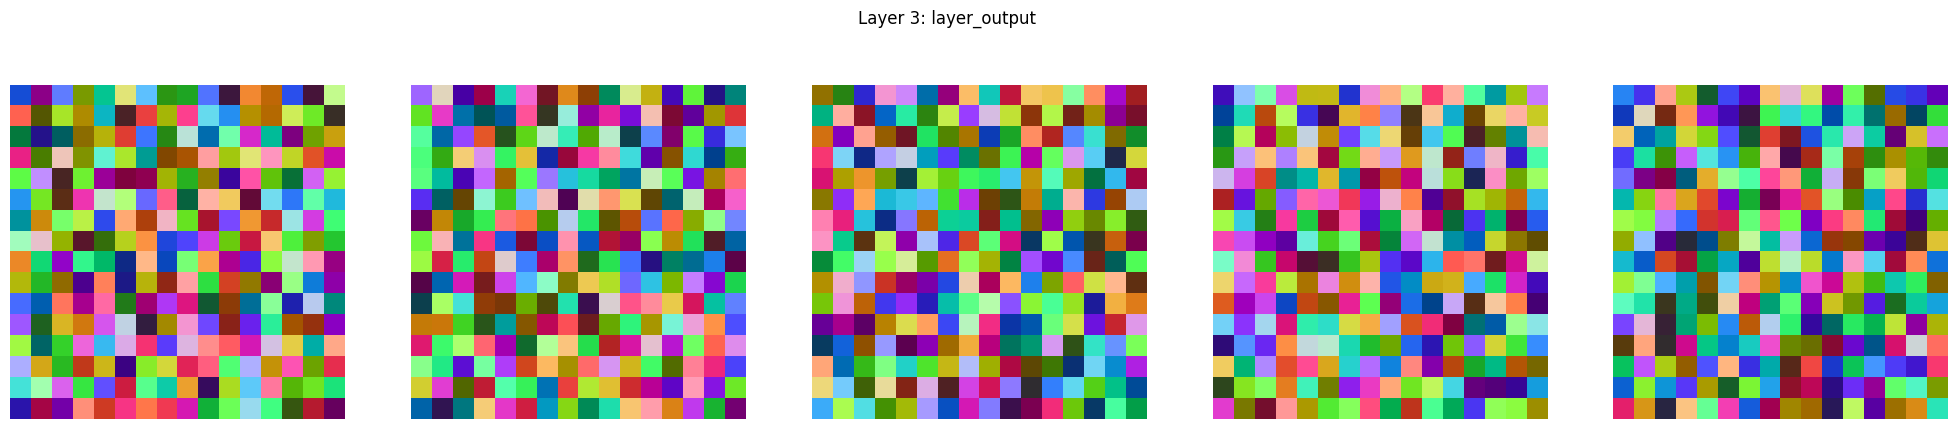

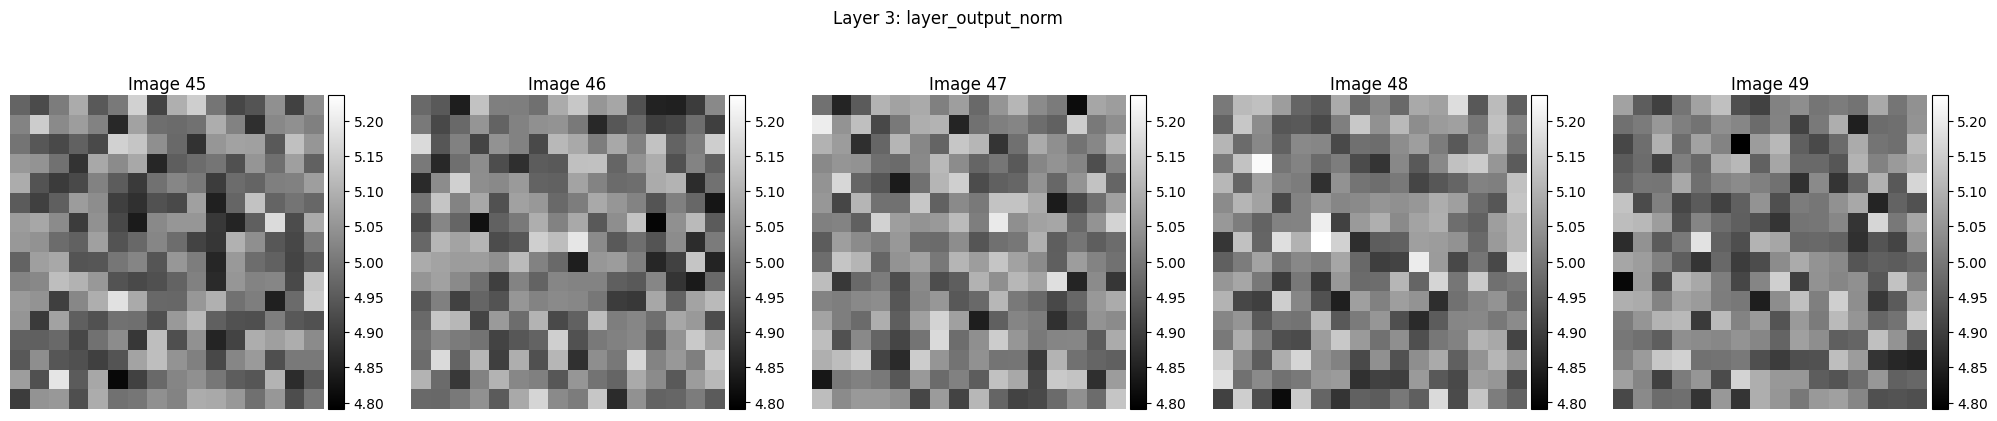

Layer 4 ========================================================================================================================


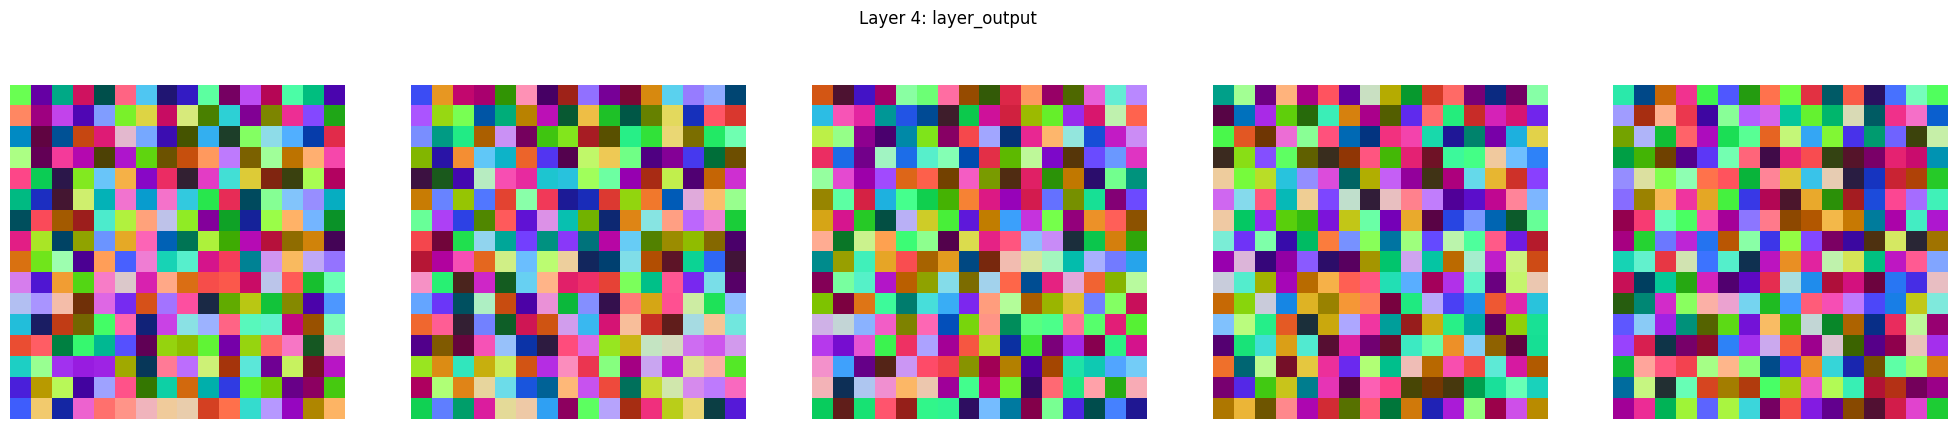

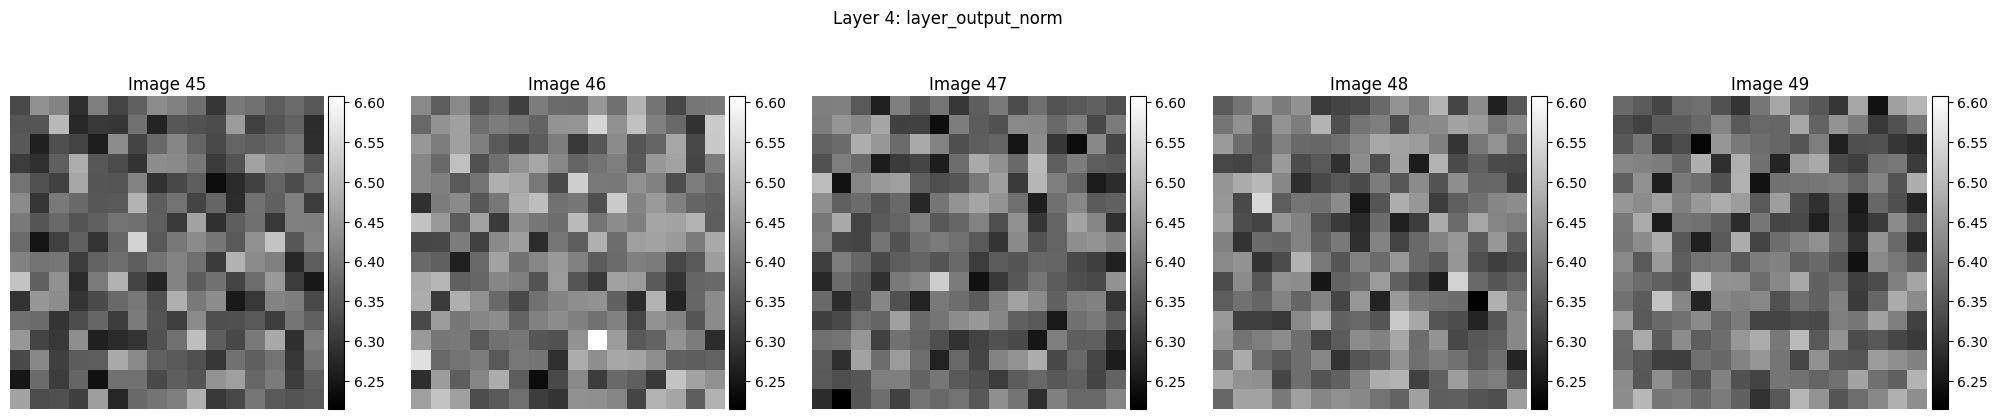

Layer 5 ========================================================================================================================


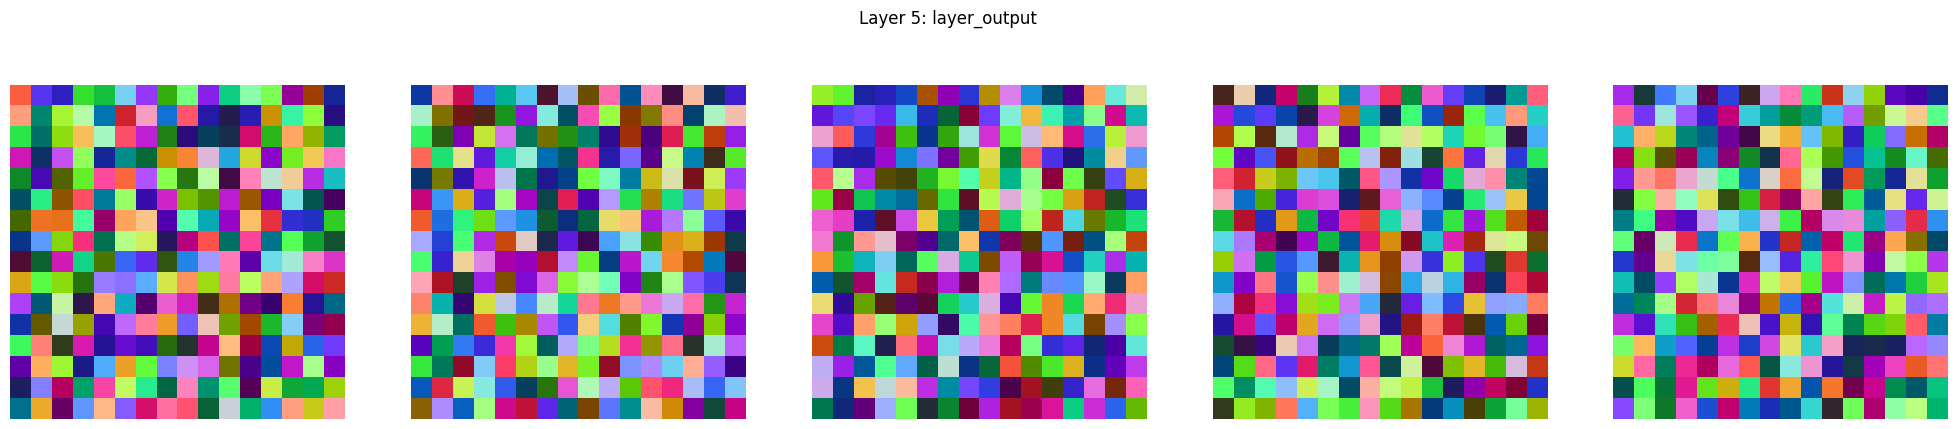

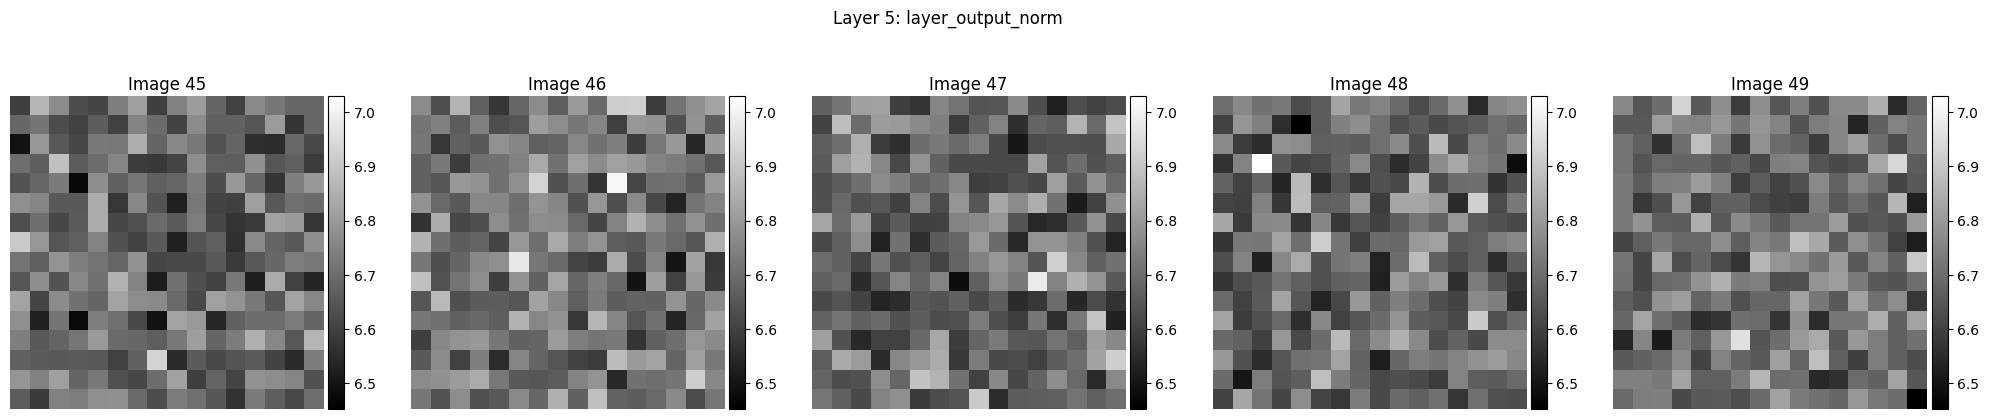

Layer 6 ========================================================================================================================


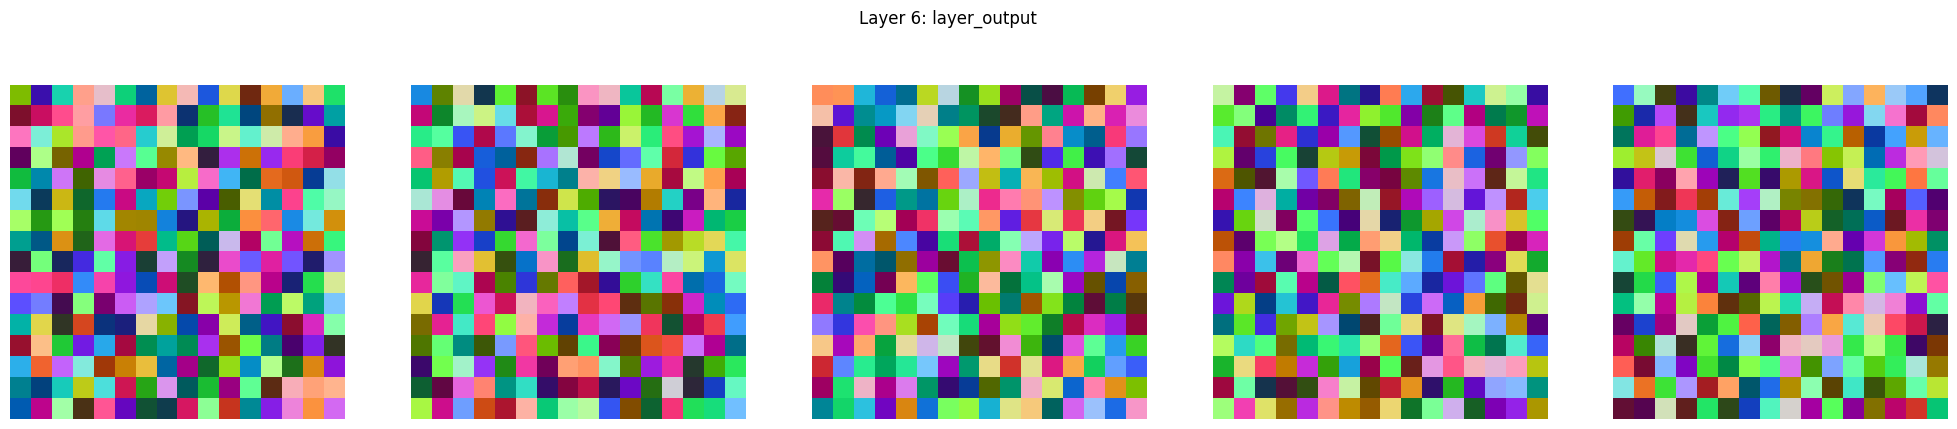

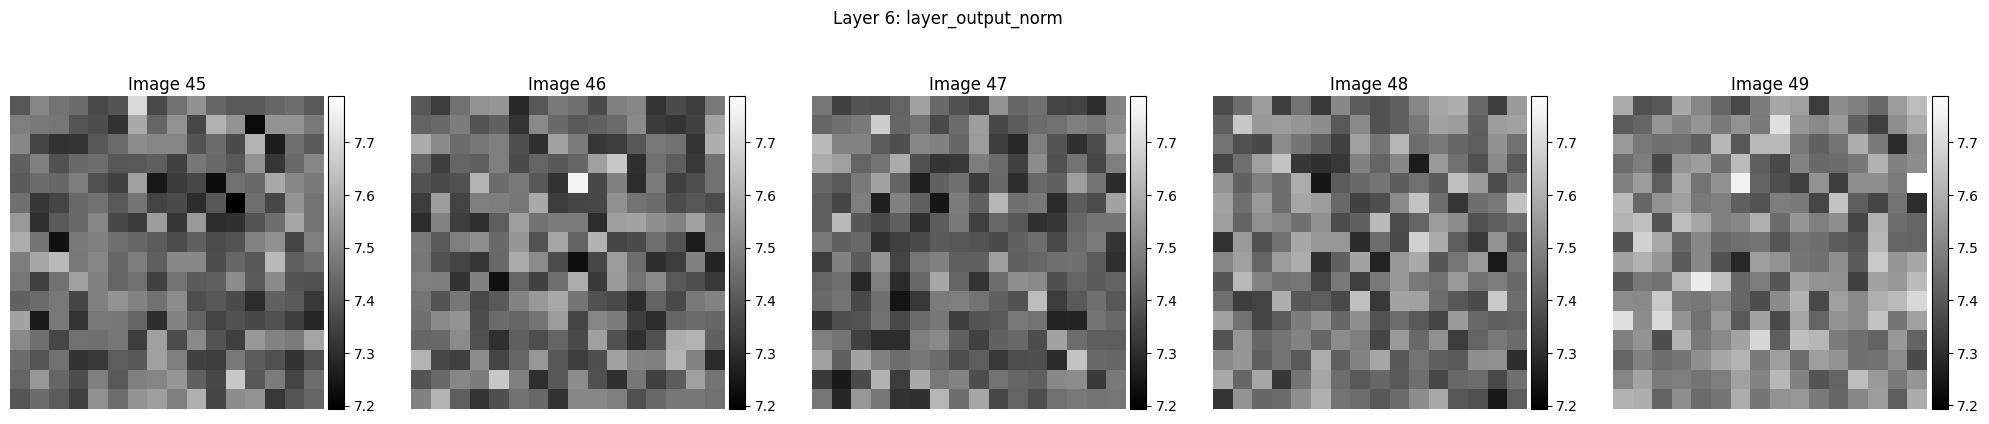

Layer 7 ========================================================================================================================


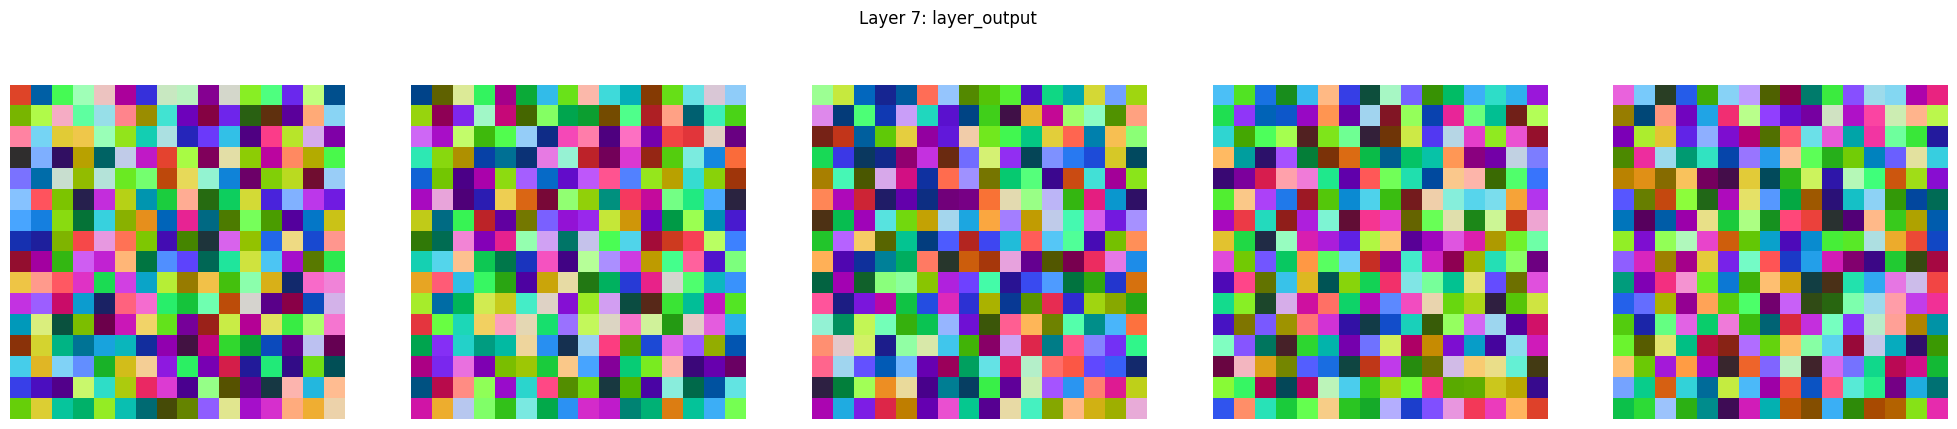

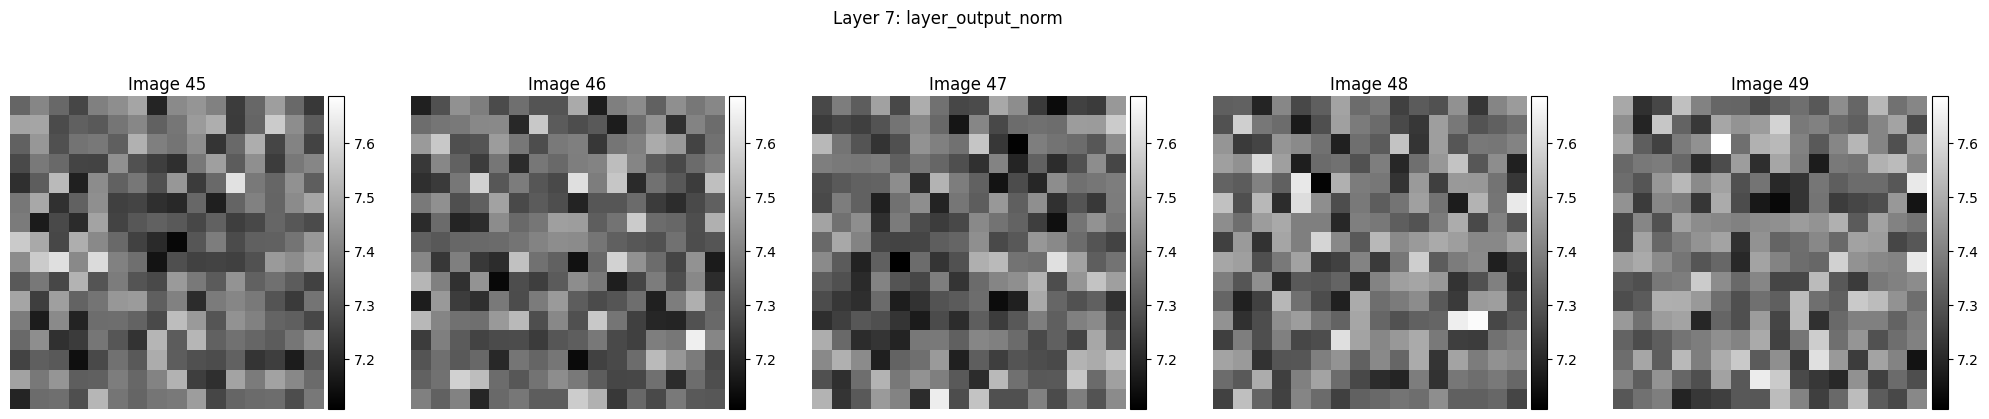

Layer 8 ========================================================================================================================


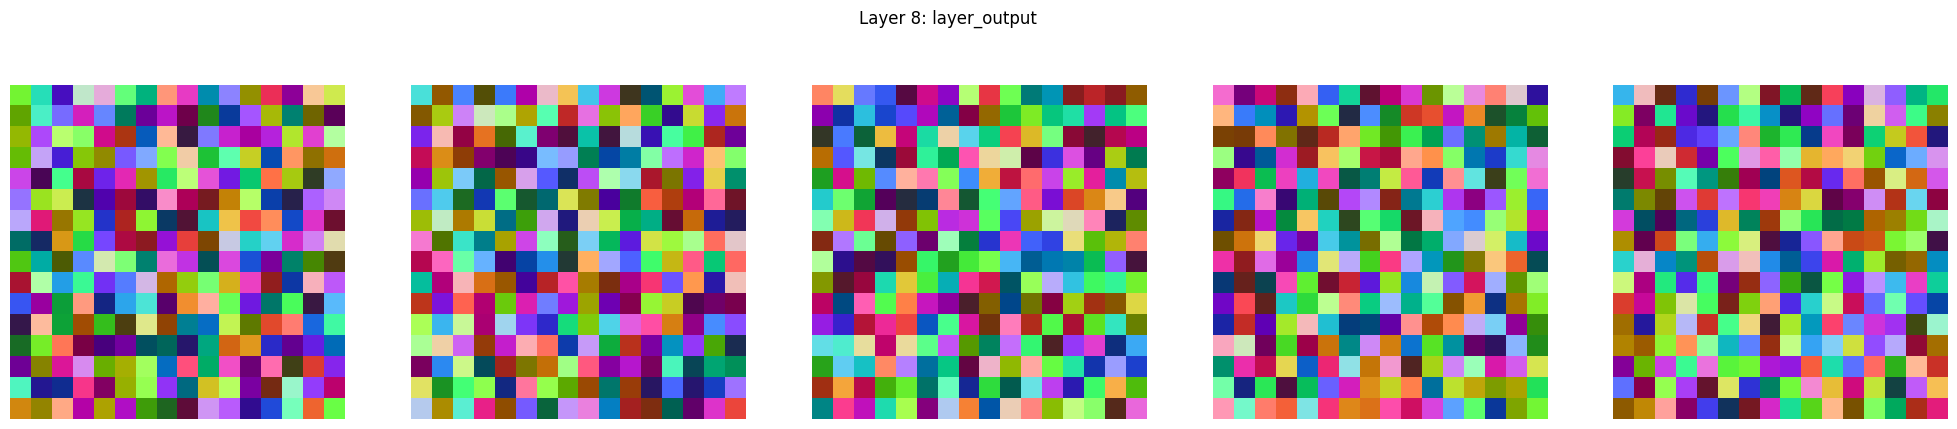

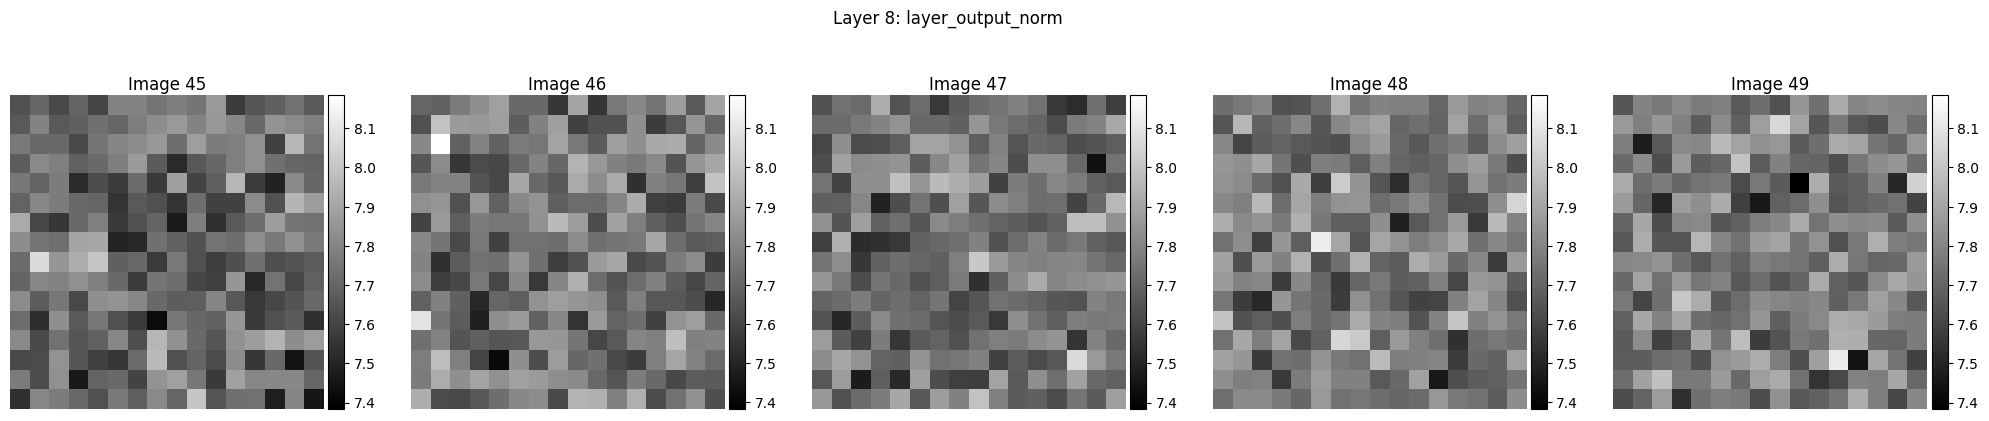

Layer 9 ========================================================================================================================


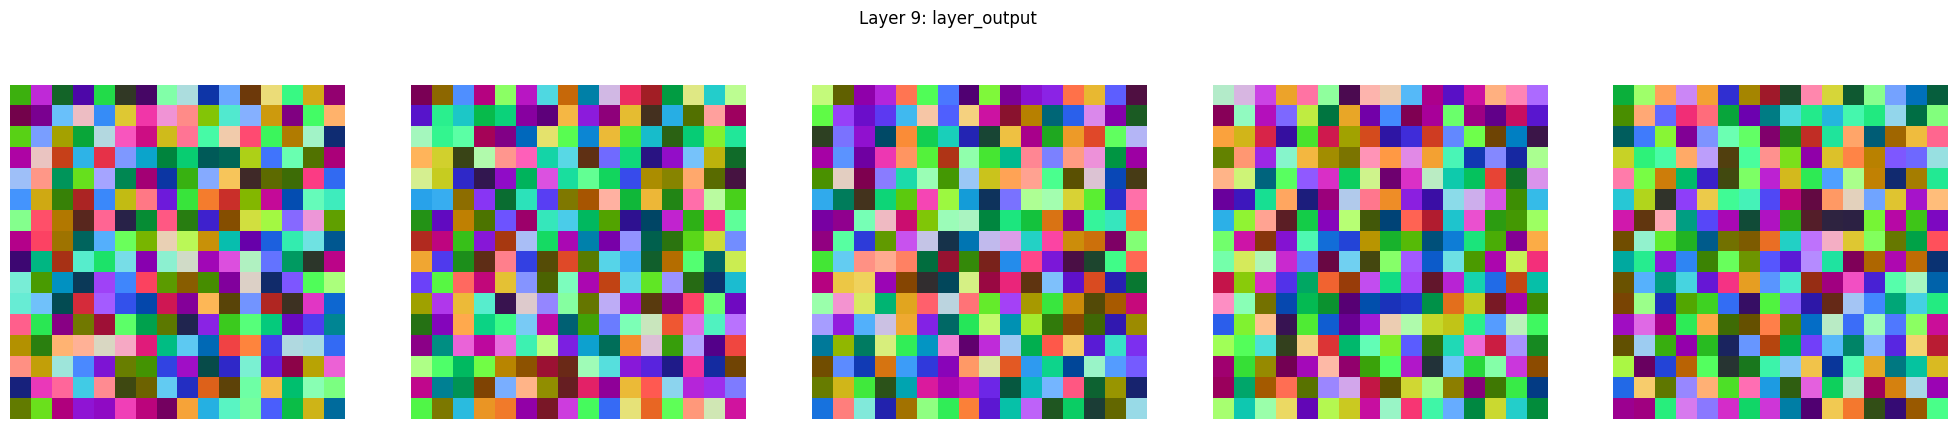

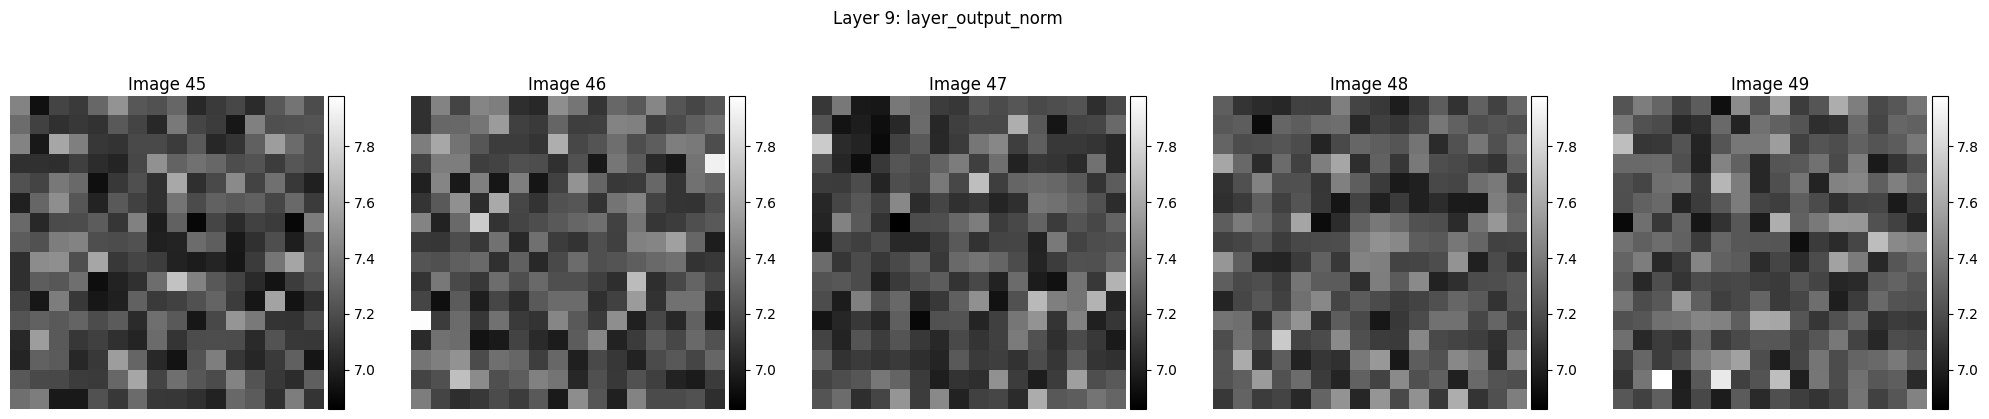

Layer 10 ========================================================================================================================


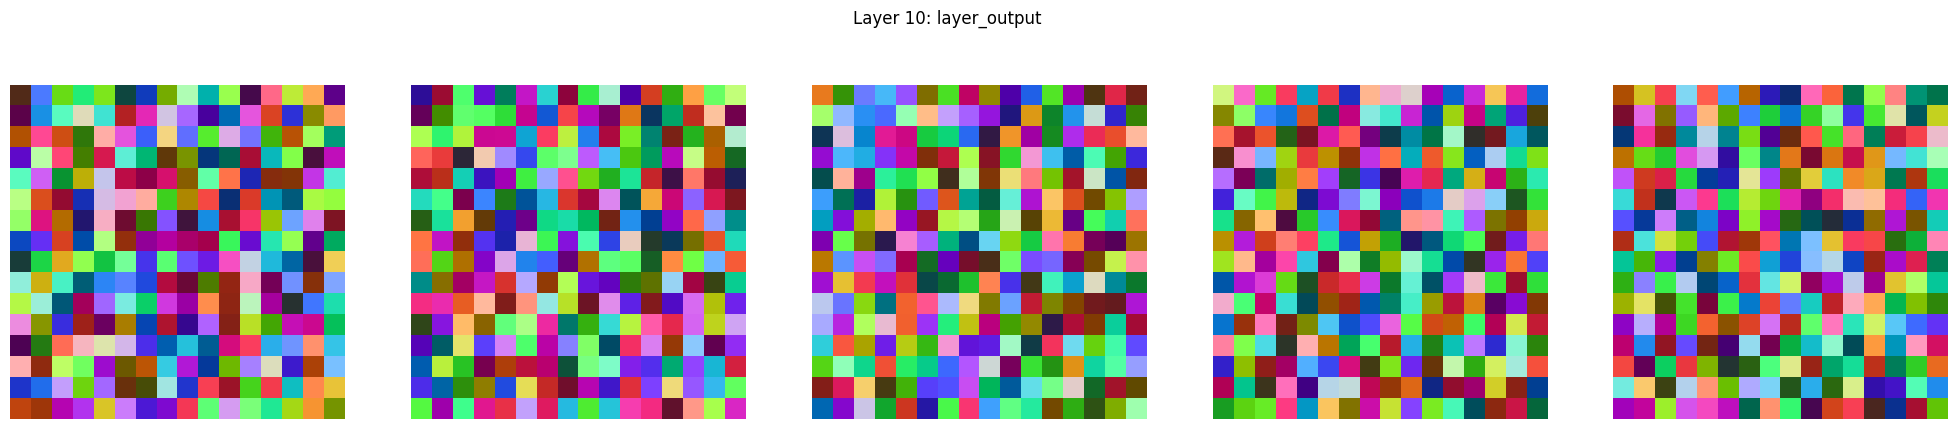

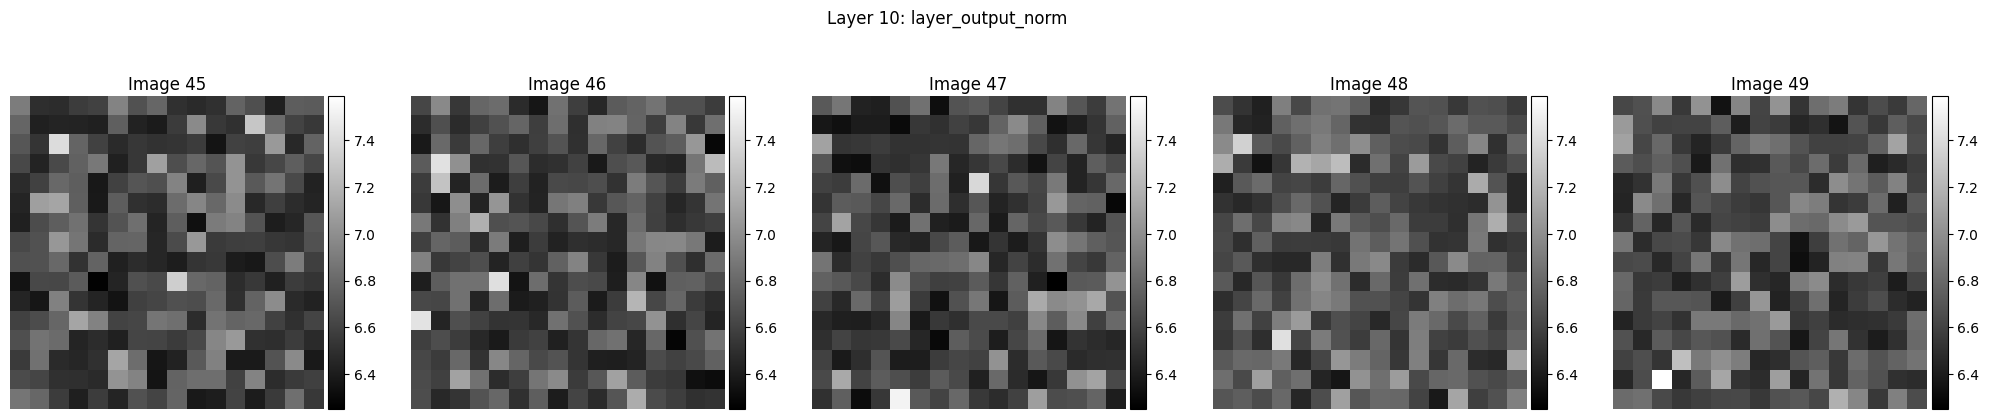

Layer 11 ========================================================================================================================


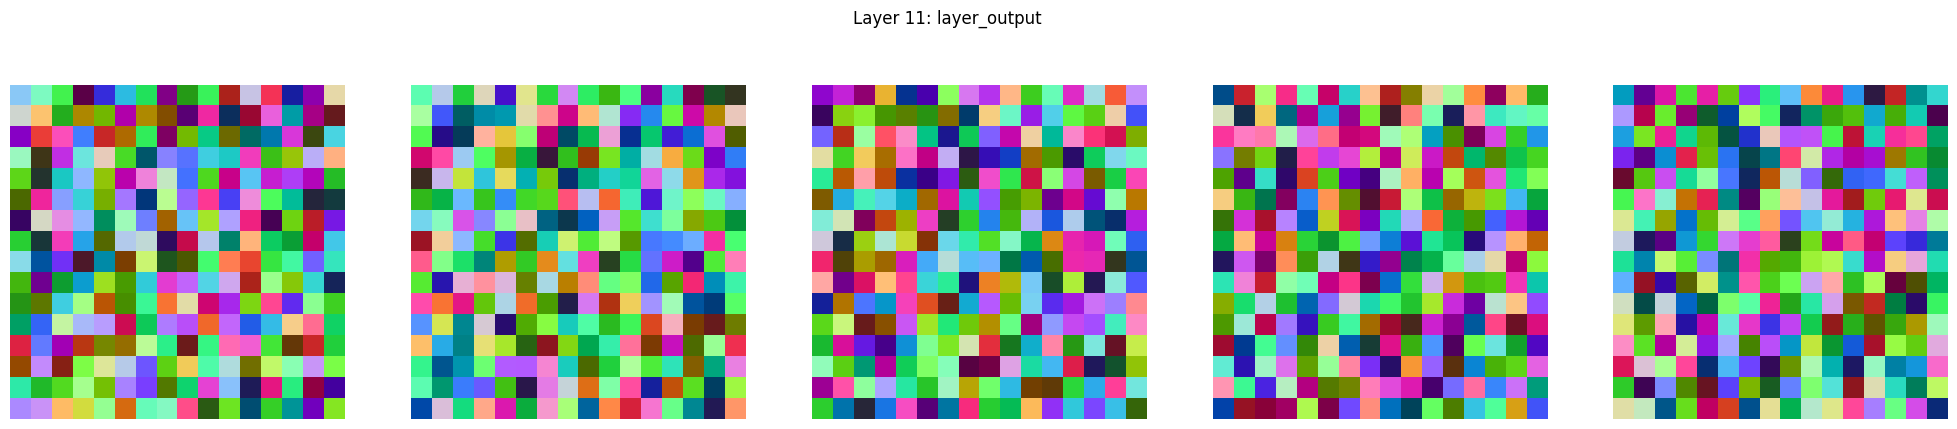

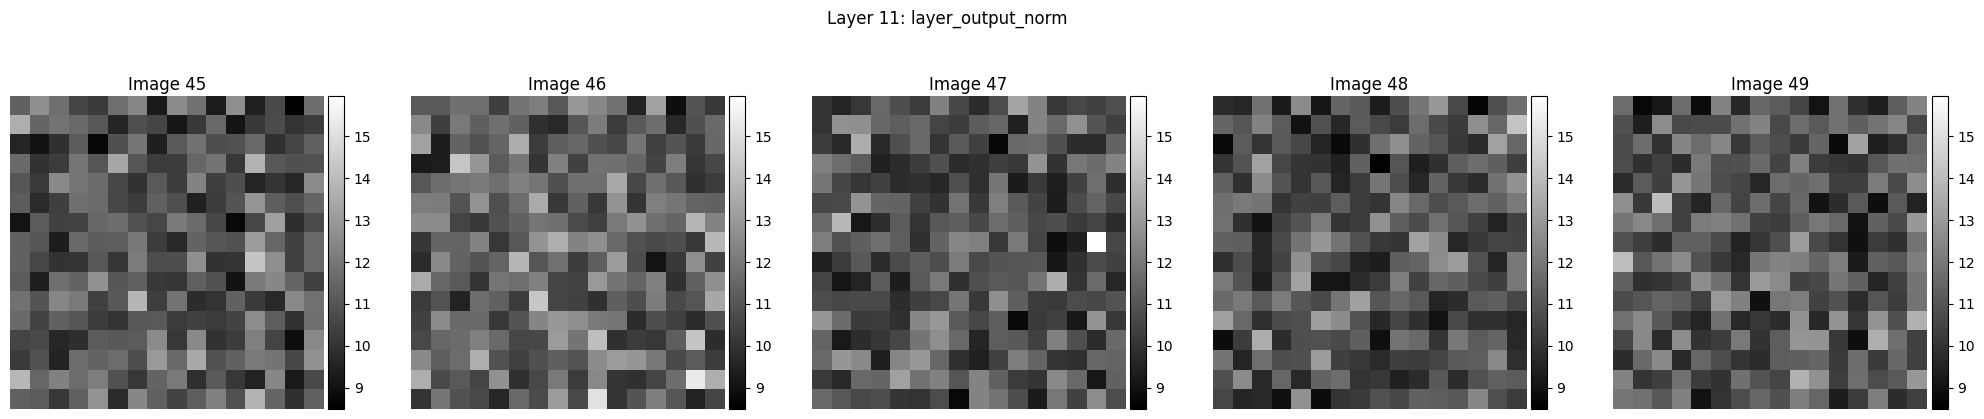

Layer 12 ========================================================================================================================


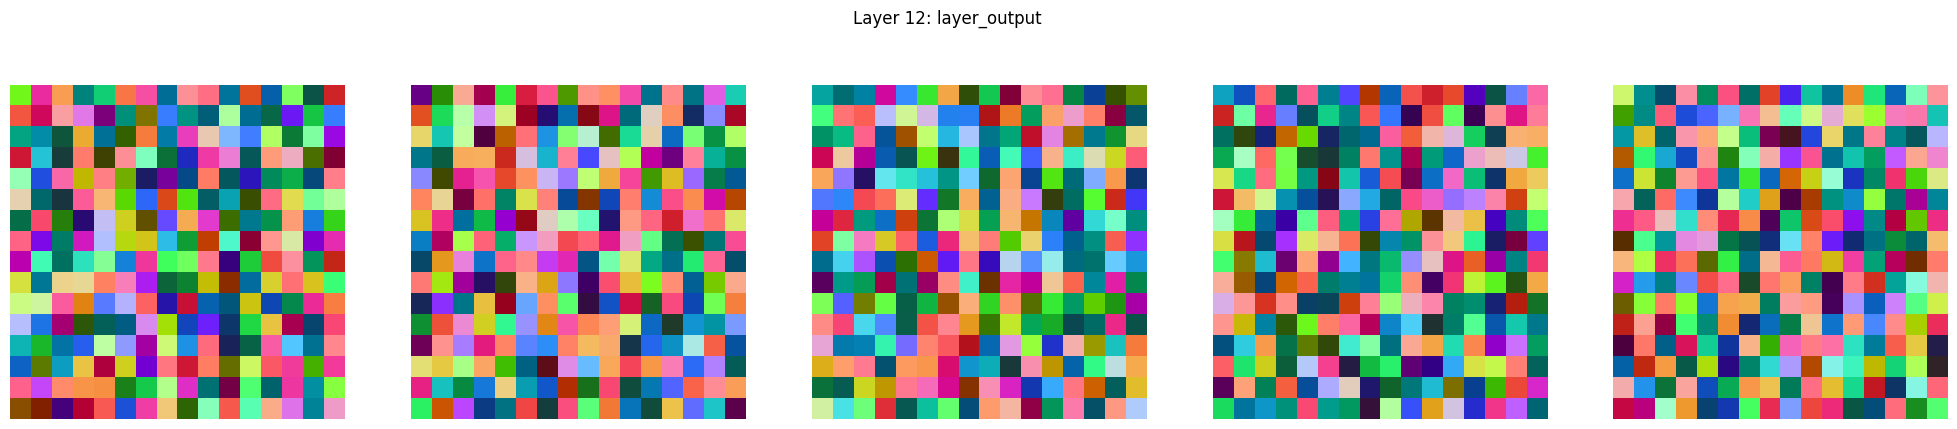

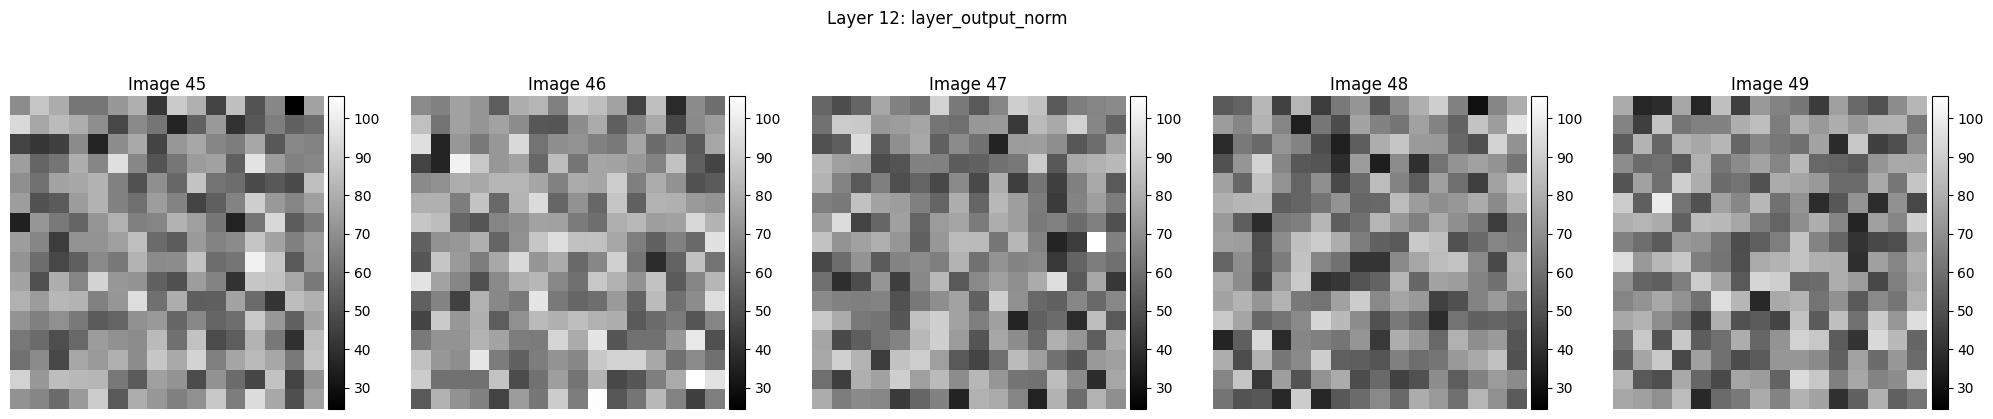

Layer 13 ========================================================================================================================


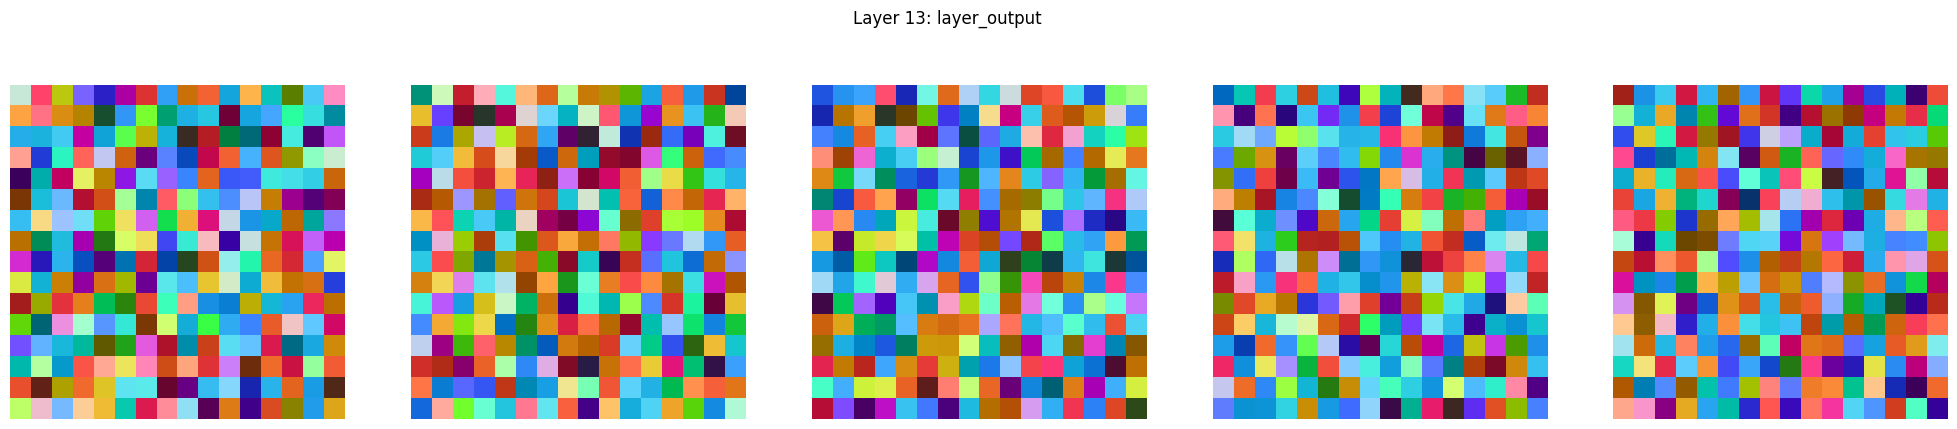

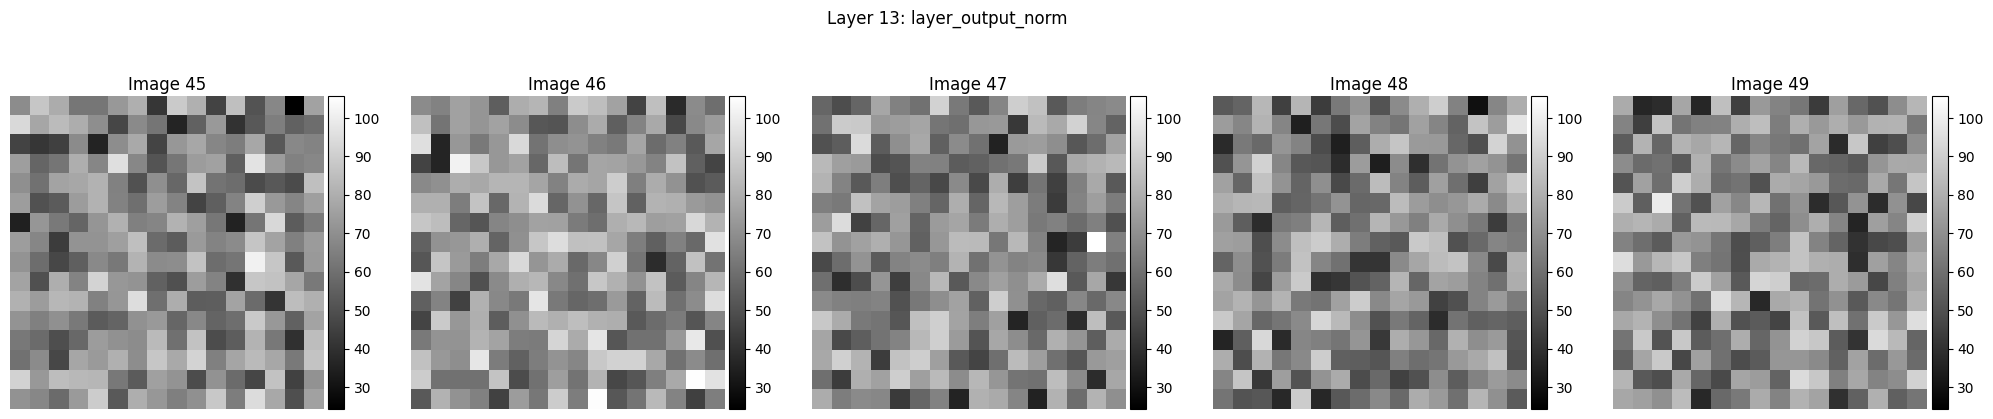

Layer 14 ========================================================================================================================


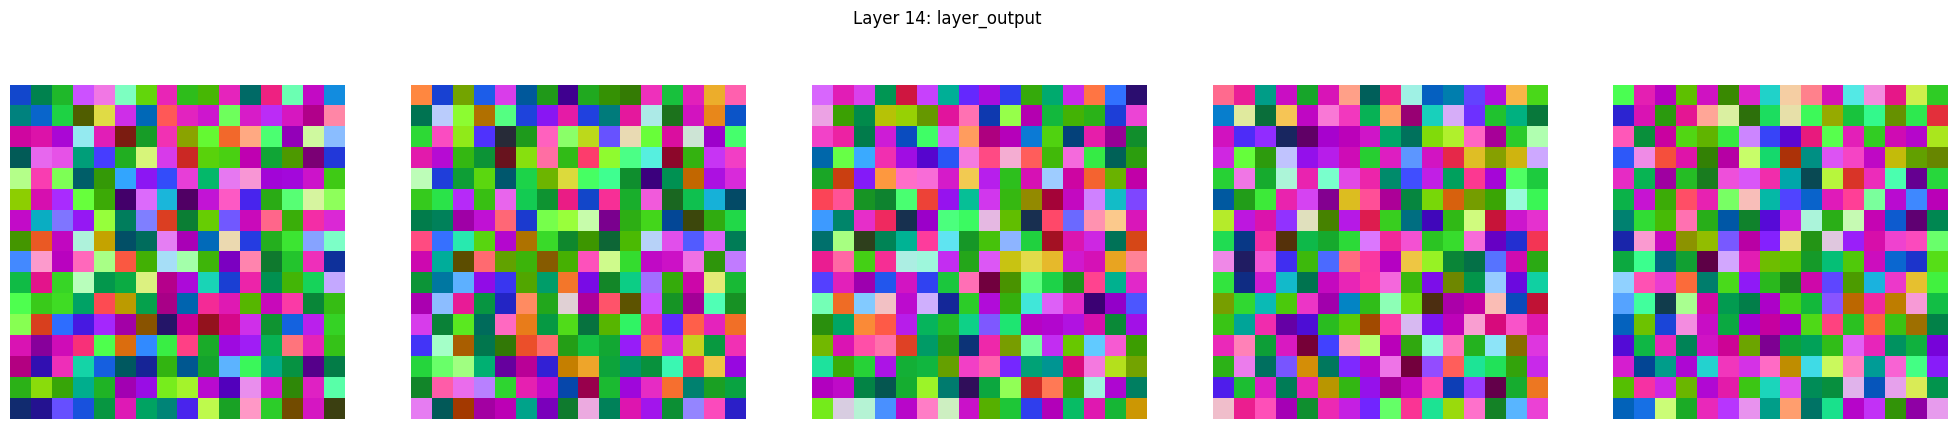

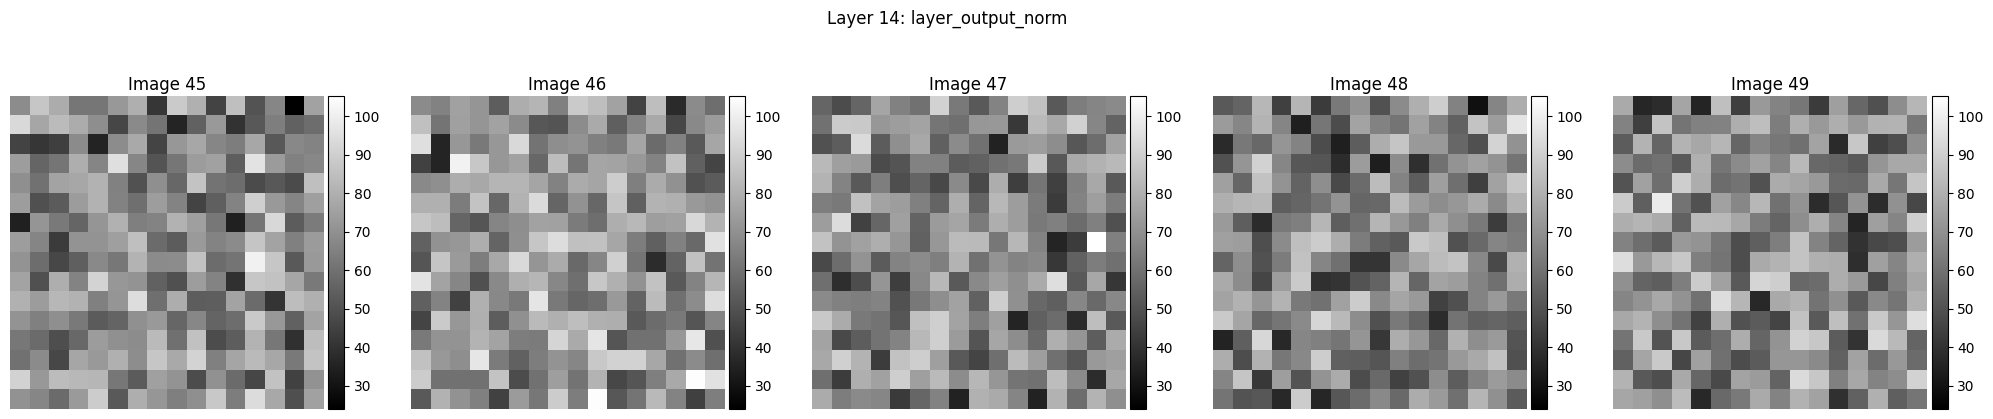

Exception: 

In [4]:
# SECTION: Per image visualization code
%matplotlib inline
from visualize.base import (
    visualize_features_per_image,
    visualize_feature_norms_per_image,
)
from visualize.attention import (
    compute_attention_contribution,
    visualize_attention_matrix_per_image,
    visualize_attention_weights_from_ma_per_image,
    visualize_incoming_attention_per_image,
    visualize_attention_weights_per_image,
)
from visualize.projections import (
    visualize_qk_projection_per_image,
    visualize_qk_projection_per_image2,
    visualize_pc_projection_per_image,
    visualize_feature_values_by_pca,
)

# for layer_idx in [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]:
# for layer_idx in [13]:
for layer_idx in model.layer_order:
    print(f"Layer {layer_idx} {'=' * 120}")
    output_dict = per_layer_output_dict[layer_idx]
    
    # visualize_attention_weights_from_ma_per_image(features, layer_idx, mta_masks, mta_aliases, cmap="viridis")
    # visualize_incoming_attention_per_image(features, layer_idx, cmap="gray")
    
    # visualize_attention_weights_per_image(
    #     features, layer_idx, mta_masks, mta_aliases, ("linear", 2), rgb_assignment,
    #     per_head=False,
    # )
    
    # visualize_feature_norms_per_image(features, layer_idx, "mlp_output", cmap="gray")
    # visualize_pc_projection_per_image(features, layer_idx, "attention_input", modes=[
    #     ("linear", 0),
    #     ("ncut", 0),
    #     ("ncut", 1),
    # ])
    # visualize_feature_norms_per_image(features, layer_idx, "query", cmap="gray")
    # visualize_feature_norms_per_image(features, layer_idx, "key", cmap="gray")
    
    for metric_name in (
        # "layer_norm1_output",
        # "query",
        # "key",
        # "attention_output",
        # "intermediate_output",
        # "layer_norm2_output",
        # "mlp_fc1_output",
        # "mlp_activation_output",
        # "mlp_output",
        "layer_output",
    ):
        # continue
        visualize_features_per_image(
            features,
            layer_idx,
            metric_name,
            mta_mask=None,
            use_all=False,
            highlight=None, # highlight,
        )
        visualize_feature_norms_per_image(features, layer_idx, metric_name, cmap="gray")
        # visualize_qk_projection_per_image(output_dict)
        continue
        visualize_pc_projection_per_image(features, layer_idx, metric_name, modes=[
            # ("linear", 0),
            # ("linear", 1),
            # ("ncut_pca", 0),
            # ("ncut_pca", 1),
            # ("ncut_pca", 2),
            # ("ncut_pca", 3),
            # ("recursive_ncut", 0),
            # ("recursive_ncut", 1),
            # ("axis_align_norm", 0),
            # ("axis_align_norm", 1),
            # ("axis_align_norm", 2),
            # ("axis_align_norm", 3),
            # ("axis_align_norm", 4),
            # ("axis_align_norm", 5),
            # ("ncut", 2),
            # ("ncut", 3),
        ])
     
        
    # # visualize_feature_norms_per_image("attention_input", output_dict["attention_input"], cmap="pink")
    # # visualize_feature_norms_per_image("attention_proj", output_dict["attention_proj"], cmap="viridis")
    
    continue
    visualize_qk_projection_per_image(
        features, layer_idx, model_dict, 
        p=0.0, aggregate_func=torch.mean,
    )
    
    # # visualize_projections_per_image(output_dict, aggregate_func=lambda t: torch.median(t, dim=-2).values, aggregate_name="median")
    # # visualize_projections_per_image(output_dict, aggregate_func=lambda t: torch.max(t, dim=-2).values, aggregate_name="max")
    # visualize_feature_norms_per_image("attention_output", output_dict["attention_output"], cmap="bone")
raise Exception()